# Digits Classification using Keras CNN

## Dataset:

The MNIST database of handwritten digits, available from [this page](http://yann.lecun.com/exdb/mnist/), has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

## Solution:

In this project we will build a Convolutional Neural Network(CNN) to find out the handwritten digits. These neural networks will be build using different layers. 

We will use Keras high-level library to perform this prediction. Tensorflow is used in backend for this network. Neural network can be build using different API's in Keras. Below are two different methods. 

1. Keras Sequential API
2. Keras Functional API

Once we build this model, we will execute the either option to run in GPU's to make faster execution and prediction.

In [11]:
# Import necessary packages

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.layers import Conv2D
from keras.layers import MaxPool2D, AvgPool2D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, LambdaCallback
from keras.layers import Flatten, Activation

from keras.layers import Input
from keras.models import Model
from keras.layers import Dropout
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [12]:
def sequential_model():
    
    """In Option 1, we are going to create a model in sequence of different steps. Here we add series of neural network layer steps to create a fully connected network and 
    then perfrom prediction using the final layer."""
    
    # Create a sequential Model
    model = Sequential()
    
    model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(28,28,1),strides=(1,1),padding='same',
                 kernel_regularizer='l2',kernel_initializer='normal'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    model.add(Activation('relu'))
    
    model.add(Flatten())
    
    model.add(Dense(units=128,activation='relu'))
    
    model.add(Dense(10,activation='softmax'))
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
    
    print('Sequential Model Summary: {}\n'.format(model.summary()))
    
    return(model)

In [48]:
def functional_model():
    
    """In Option 2, we will use the sophisticated functions API provided by Keras. My using this method, we can provide multiple inputs in various different forms. 
    It also has lot of flexibility compared to the Sequential API."""
    #Input shape of the data
    inputs = Input(shape=(28,28,1))
    
    #Adding multiple layers as we performed in Sequential API

    x = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),kernel_regularizer='l2', \
               kernel_initializer='normal')(inputs)
    
    x = MaxPool2D(pool_size=(2,2))(x)
    
    x= Dropout(0.1)(x)
    x= BatchNormalization()(x)
    x = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),kernel_regularizer='l2', \
               kernel_initializer='normal')(x)
    
    x = MaxPool2D(pool_size=(2,2))(x)
    
    x= Dropout(0.1)(x)
    x= BatchNormalization()(x)

    x = Dense(128,activation='relu')(x)
    x = Flatten()(x)
    
    predictions = Dense(10,activation='softmax')(x)
    
    #Create a model and predict
    model = Model(inputs=inputs, outputs=predictions)
    
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
    
    print('Functional Model Summary: {}\n'.format(model.summary()))

    
    return(model)

In [28]:
def generate_call(X_train, X_test, y_train_cat, y_test_cat):
    """Another complexity we are going to add to this model is to perform image generation. We are going to add new images by recaling, shifting width, height, rotation, shear, zoom and horizontal flip, etc. 
    By performing this operation, we can generate new images and by confident about our model and predictions."""
    
    train_gen = ImageDataGenerator(rescale = 1./255,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           rotation_range = 10,
                           shear_range = 0.2,
                           zoom_range = 0.2,
                           horizontal_flip = True)
    test_gen = ImageDataGenerator(rescale = 1./255)

    tra = train_gen.flow(X_train,y_train_cat)
    
    #After adding new images, lets see a sample image and its output. By seeing these outputs, some images have been got totally transformed. 
    #Lets see how the model behaves on these totally transformed images.
    #for t in tra:
        #print(t[0][0].reshape(28,28))
    #    plt.imshow(t[0][0].reshape(28,28),cmap='gray')
    #    print("Actual number is {}\n".format(np.argmax(t[1][0])))
    #    break
            
    return train_gen, test_gen

In [29]:
def consolidated_model( X_train, X_test, y_train_cat, y_test_cat,image_generate=False,model_type='Sequential'):
    
    """Below is the series of steps added to the model
    1. Add a convolutional 2D layer with the kernal size of 3x3 and strides of 1x1.
    2. We can add l2 regularizer and initiate the kernel weigths to normal weights.
    3. Add MaxPool2D layer, which reduces the image size with 2x2 kernal size. It will try to detect the corners and important features.
    4. Randomly dropout the 10% of neurons. This will prevent the model to be dependent on some certain neurons.
    5. Add BatchNormalization will transorm the previous layers output mean close to 0 and the SD close to 1.
    6. Adding all the previous steps (convolution2D, MaxPool2D, Dropout, BatchNormalization) to the model.
    7. Adding the activation function Relu.
    8. Flatten the complete array to create a Fully connectected neural network.
    9. Add a output layer with 128 neurons with relu activation.
    10. Finally add a softmax layer with 10 output neurons to predict the output.
    11. Complie the model with RMSPROP optimzer and categorical cross entropy loss with accuracy as the metric.
    """
    
    if model_type =='Sequential':
        model = sequential_model()
        
    elif model_type=='Functional':
        model = functional_model()
    

    # Creating some call back functions
    earlystopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=5, mode ='auto')
    #Tensorboard logs
    tensorboard = TensorBoard(log_dir='./logs')
    
    
    if image_generate ==True:
        train_gen, test_gen = generate_call(X_train, X_test, y_train_cat, y_test_cat)
        
        #Saving best model
        modelcheckpoint = ModelCheckpoint('./model/save_model_fit_generator.hdf5', monitor ='val_loss',save_best_only=True,)

        #Fit method provides higher accuracy but we did not generate new images which is of different sizes, zoom, etc. Below fit method will will use the newly generated images and then perform fit method.
        #Image generator creates an generator object, so we have to use flow method to generate new images. This method is extremely slow, so we are performing only two epochs.

        model.fit_generator(train_gen.flow(X_train,y_train_cat),epochs=10,steps_per_epoch=len(X_train)
                   ,callbacks =[earlystopping,modelcheckpoint,tensorboard])
        
        
        #print("Evaluate model accuracy with new images: {}".format(model.evaluate(X_test,y_test_cat)))

        
    elif image_generate ==False:
        
        modelcheckpoint = ModelCheckpoint('./model/save_model_fit.hdf5', monitor ='val_loss',save_best_only=True)
    
        #Fitting the model with a batch size of 128 and 10 epochs without any new image generator. This provides higher accuracy
        
        model.fit(X_train,y_train_cat,batch_size=128,validation_split=0.1,
                  epochs=100,callbacks =[earlystopping,modelcheckpoint,tensorboard])
        
        
        print("Evaluate model accuracy without new images: {}".format(model.evaluate(X_test,y_test_cat)[1] *100))
    
    return(model)

Validating the shape of X_train: (60000, 28, 28)

Validating the shape of X_test:(10000, 28, 28)


***Sequentional without new generated images***

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 800)               0    

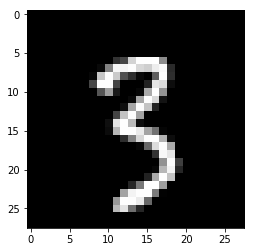

In [47]:
if __name__=='__main__':
    
    #MNIST dataset is conveniently available as part of Keras.datasets library. We will import the dataset and split it in Train test split in random order.
    
    (X_train, y_train), (X_test, y_test) = mnist.load_data('mnist.npz')
    
    print("Validating the shape of X_train: {}\n".format(X_train.shape))
    print("Validating the shape of X_test:{}\n".format(X_test.shape))
    
    #Image of random train object
    plt.imshow(X_train[9999],cmap='gray')
    
    #The image pixel range is from 0 to 255. We need to convert it to float and divide by 255. By performing this we will reduce the computations carred by neural network.
    
    # Convert integer to float and divide by 255
    X_train = X_train.astype('float32')/255
    X_test = X_test.astype('float32')/255
    
    
    #To perform convolution on the image, we need to convert the image into 28x28 pixels. Also the input needs to be a rank 4 tensor. First input is the number of rows, here -1 means it will fetch at run time. Other two dimentions are image pixels. Final dimension mentions the image color. 
    #In our case, it is gray scale so it is mentioned as 1.
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    
    #Converting to y to categorical variable
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)
    
    #Sequential call
    
    print("\n***Sequentional without new generated images***\n")
    model = consolidated_model(X_train, X_test, y_train_cat, y_test_cat,image_generate=False,model_type='Functional')
    
    print("\n***Sequentional with new images***\n")
    
    model = consolidated_model(X_train, X_test, y_train_cat, y_test_cat,image_generate=True,model_type='Sequential')   